In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import plotly.express as px

In [2]:
telemetry = pd.read_csv('tmdata_imputed.csv')
telemetry.head()

,AssetID,FullDate,Date,Time,snoIdentifier,tidIdentifier,Reading,YM,Year,Month,delta_premerge,delta_pm_mins,BST_Y,Invalid_Y,OriginalRecord_Y,Reading_Imp
0,1E09474,2019-01-01 00:00:00,2019-01-01,00:00:00,1.0,E09474,42.10,2019-01,2019.0,1.0,NaN,NaN,0,0,1,42.10
1,1E09474,2019-01-01 00:15:00,2019-01-01,00:15:00,1.0,E09474,32.13,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,32.13
2,1E09474,2019-01-01 00:30:00,2019-01-01,00:30:00,1.0,E09474,30.31,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,30.31
3,1E09474,2019-01-01 00:45:00,2019-01-01,00:45:00,1.0,E09474,40.08,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,40.08
4,1E09474,2019-01-01 01:00:00,2019-01-01,01:00:00,1.0,E09474,34.63,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,34.63


In [3]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417166 entries, 0 to 417165
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AssetID           417166 non-null  object 
 1   FullDate          417166 non-null  object 
 2   Date              417166 non-null  object 
 3   Time              417166 non-null  object 
 4   snoIdentifier     414900 non-null  float64
 5   tidIdentifier     414900 non-null  object 
 6   Reading           413965 non-null  float64
 7   YM                414900 non-null  object 
 8   Year              414900 non-null  float64
 9   Month             414900 non-null  float64
 10  delta_premerge    414899 non-null  object 
 11  delta_pm_mins     414899 non-null  float64
 12  BST_Y             417166 non-null  int64  
 13  Invalid_Y         417166 non-null  int64  
 14  OriginalRecord_Y  417166 non-null  int64  
 15  Reading_Imp       417166 non-null  float64
dtypes: float64(6), int64

In [4]:
telemetry[['Reading','Reading_Imp']].groupby(telemetry['AssetID']).describe()

Reading                                                          \
            count       mean        std    min     25%        50%     75%   
AssetID                                                                     
1E09474  105207.0  49.172075  19.941375 -0.090  34.270  45.830000  63.230   
1E18034  100890.0   3.372927   1.499496  0.000   2.160   3.380000   4.440   
3E03007  105096.0  32.341418  12.937254 -0.290  22.090  29.130015  43.030   
3E43383  102772.0   1.658619   1.920237 -0.012   0.909   1.363000   1.918   

                 Reading_Imp                                               \
             max       count       mean        std    min     25%     50%   
AssetID                                                                     
1E09474  120.090    105216.0  49.172386  19.941289 -0.090  34.270  45.830   
1E18034   20.000    101518.0   3.379566   1.499020  0.000   2.170   3.390   
3E03007   59.870    105216.0  32.341606  12.937097 -0.290  22.090  29.140   
3E43383   15.012    105216.0   1.728432   2.055535 -0.012   0.914   1.377   

                          
            75%      max  
AssetID                   
1E09474  63.230  120.090  
1E18034   4.440   20.000  
3E03007  43.030   59.870  
3E43383   1.956   15.012

<AxesSubplot:xlabel='value', ylabel='AssetID'>

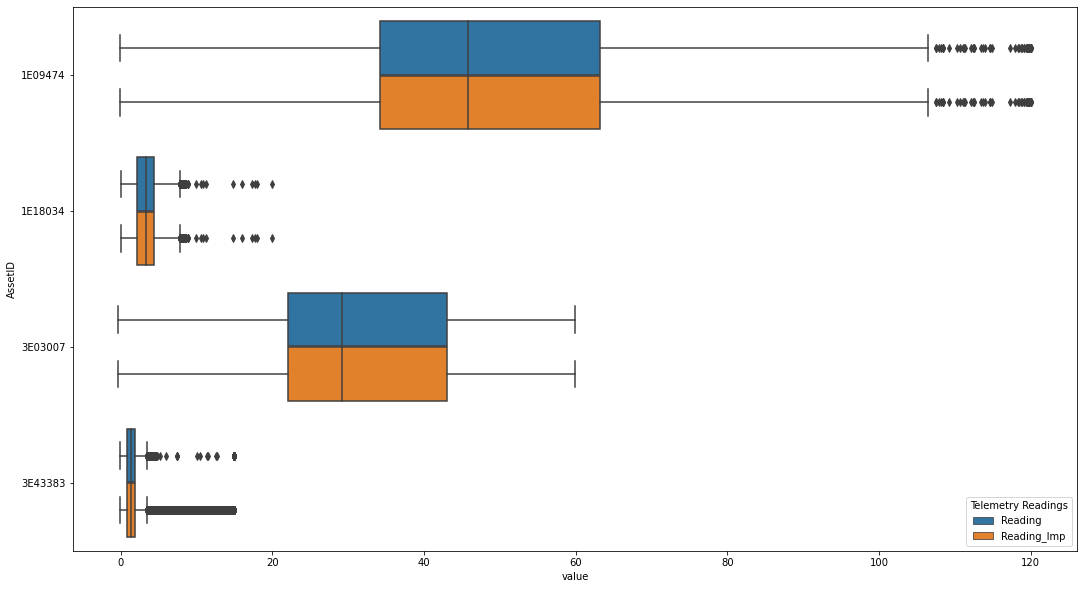

In [5]:
#Drawing a boxplot
tm_long = pd.melt(telemetry, id_vars=['AssetID'], value_vars=['Reading','Reading_Imp'], var_name='Telemetry Readings')

plt.rcParams['figure.figsize']=(18,10)
sns.boxplot(y='AssetID',x='value',data=tm_long,orient="h", hue='Telemetry Readings')

In [6]:
def outliers(telemetry, reading):
    Q1= telemetry[reading].groupby(telemetry['AssetID']).quantile(0.25)
    Q3 = telemetry[reading].groupby(telemetry['AssetID']).quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit
upper, lower = outliers(telemetry, 'Reading_Imp')
print("Upper whisker: ", upper)
print("Lower Whisker: ", lower)

Upper whisker:  AssetID
1E09474    106.670
1E18034      7.845
3E03007     74.440
3E43383      3.519
Name: Reading_Imp, dtype: float64
Lower Whisker:  AssetID
1E09474   -9.170
1E18034   -1.235
3E03007   -9.320
3E43383   -0.649
Name: Reading_Imp, dtype: float64


In [7]:
def outliers_3std(telemetry, reading):
    upper_limit = telemetry[reading].groupby(telemetry['AssetID']).mean() + 3 * telemetry[reading].groupby(telemetry['AssetID']).std()
    lower_limit = telemetry[reading].groupby(telemetry['AssetID']).mean() - 3 * telemetry[reading].groupby(telemetry['AssetID']).std()
    return upper_limit, lower_limit
upper_limit, lower_limit = outliers_3std(telemetry, 'Reading_Imp')
print("Upper limit: ", upper_limit)
print("Lower Limit: ",lower_limit)

Upper limit:  AssetID
1E09474    108.996252
1E18034      7.876625
3E03007     71.152898
3E43383      7.895036
Name: Reading_Imp, dtype: float64
Lower Limit:  AssetID
1E09474   -10.651480
1E18034    -1.117493
3E03007    -6.469686
3E43383    -4.438172
Name: Reading_Imp, dtype: float64


In [8]:
# telemetry['z_score'] = (telemetry.groupby(telemetry['AssetID'])['Reading_Imp'] - telemetry.groupby(telemetry['AssetID'])['Reading_Imp'].mean()) / telemetry.groupby(telemetry['AssetID'])['Reading_Imp'].mean().std()
# telemetry.head()

In [9]:
#Converting the 'Fulldate' field data type from object to datetime
telemetry['FullDate'] = pd.to_datetime(telemetry['FullDate'], format = '%Y-%m-%d %H:%M:%S')

In [10]:
telemetry['FullDate'].dtypes

dtype('<M8[ns]')

array([<AxesSubplot:xlabel='FullDate'>, <AxesSubplot:xlabel='FullDate'>,
       <AxesSubplot:xlabel='FullDate'>, <AxesSubplot:xlabel='FullDate'>],
      dtype=object)

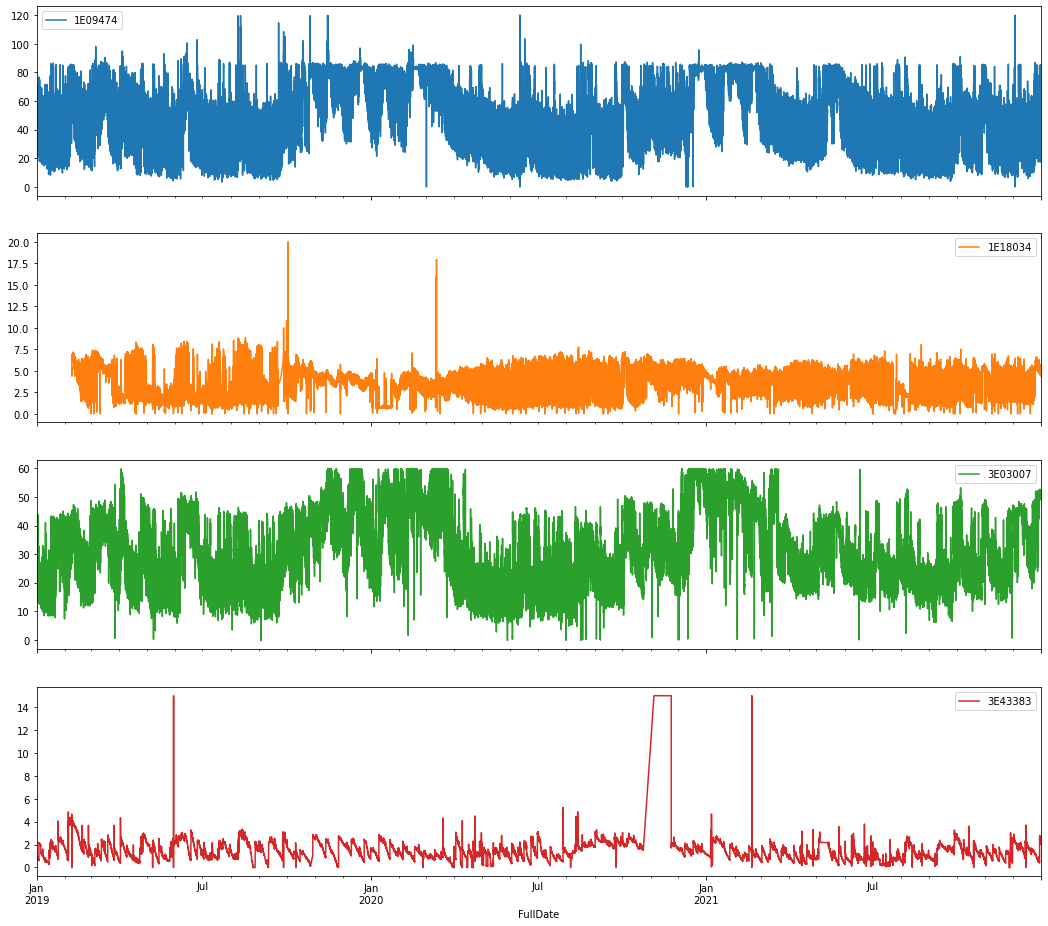

In [11]:
telemetry.pivot_table(index='FullDate',columns='AssetID',values='Reading_Imp').plot(figsize=(18,16),subplots=True)

Text(0, 0.5, '3E43383 Seasonal')

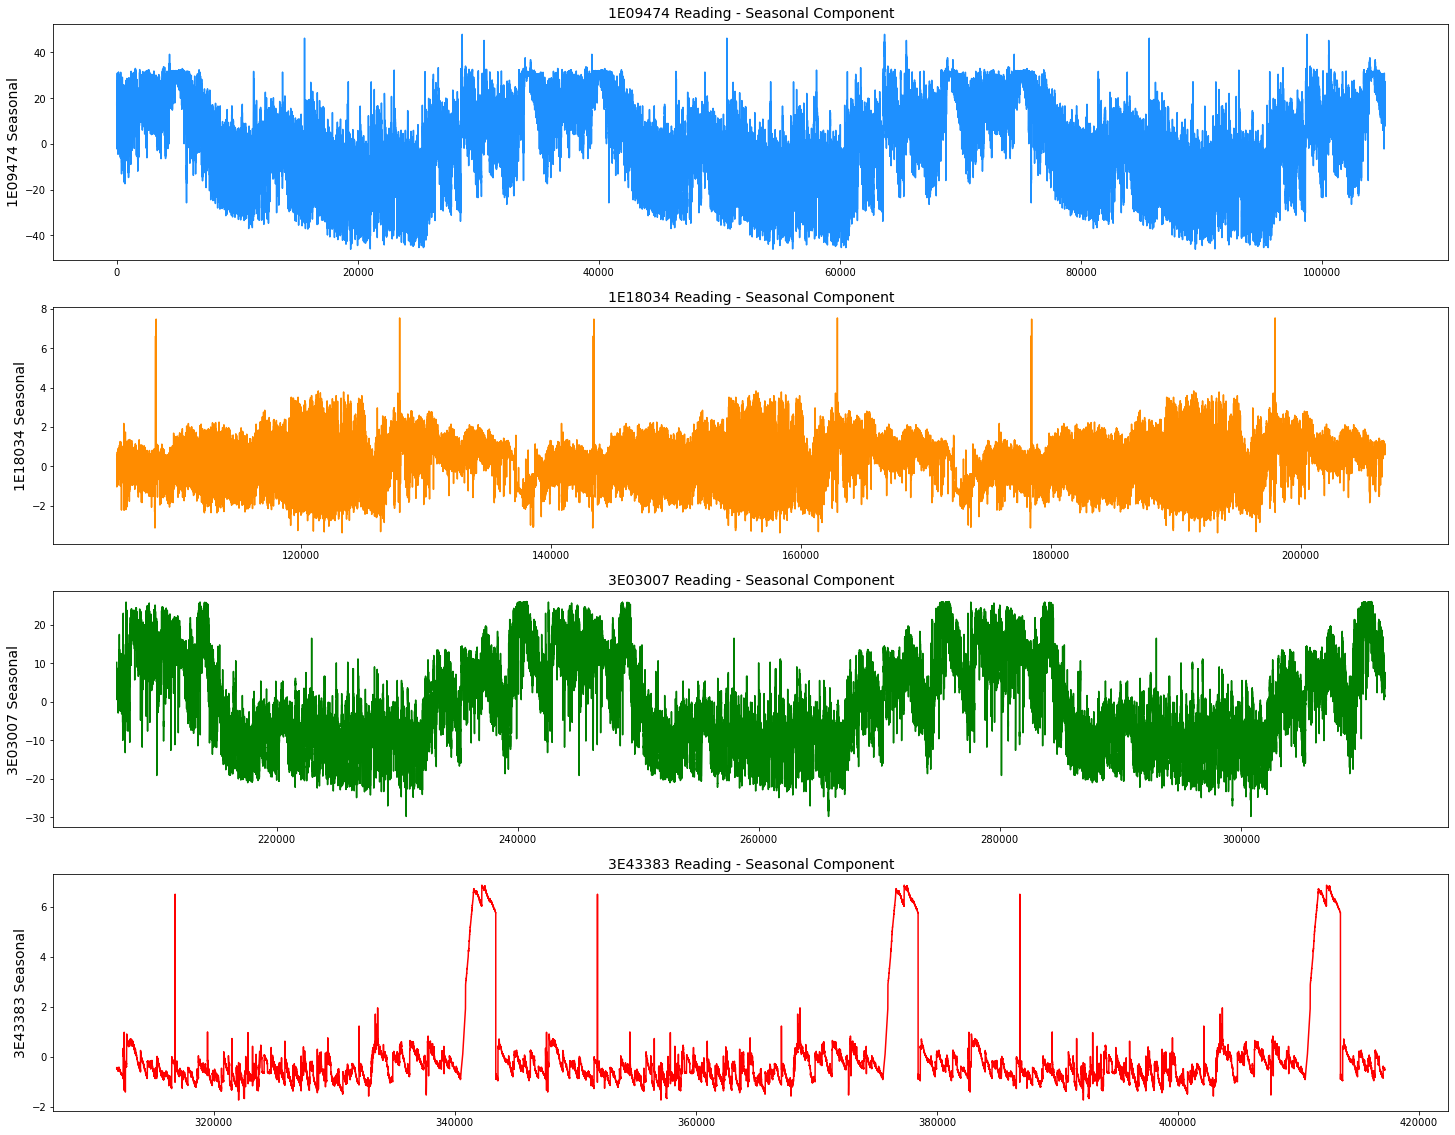

In [12]:
#Seasonal plot for each asset
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 20))

df_1E09474 = telemetry.loc[telemetry['AssetID'] == '1E09474']
result_1E09474 =seasonal_decompose(df_1E09474['Reading_Imp'], model='additive', period=35040)
result_1E09474.seasonal.plot(ax=ax[0], color='dodgerblue', label = 'seasonal')
ax[0].set_title(f'1E09474 Reading - Seasonal Component', fontsize=14)
ax[0].set_ylabel(ylabel='1E09474 Seasonal', fontsize=14)

df_1E18034 = telemetry.loc[telemetry['AssetID'] == '1E18034']
result_1E18034 =seasonal_decompose(df_1E18034['Reading_Imp'], model='additive', period=35040)
result_1E18034.seasonal.plot(ax=ax[1], color='darkorange', label = 'seasonal')
ax[1].set_title(f'1E18034 Reading - Seasonal Component', fontsize=14)
ax[1].set_ylabel(ylabel='1E18034 Seasonal', fontsize=14)

df_3E03007 = telemetry.loc[telemetry['AssetID'] == '3E03007']
result_3E03007 =seasonal_decompose(df_3E03007['Reading_Imp'], model='additive', period=35040)
result_3E03007.seasonal.plot(ax=ax[2], color='green', label = 'seasonal')
ax[2].set_title(f'3E03007 Reading - Seasonal Component', fontsize=14)
ax[2].set_ylabel(ylabel='3E03007 Seasonal', fontsize=14)

df_3E43383 = telemetry.loc[telemetry['AssetID'] == '3E43383']
result_3E43383 =seasonal_decompose(df_3E43383['Reading_Imp'], model='additive', period=35040)
result_3E43383.seasonal.plot(ax=ax[3], color='red', label = 'seasonal')
ax[3].set_title(f'3E43383 Reading - Seasonal Component', fontsize=14)
ax[3].set_ylabel(ylabel='3E43383 Seasonal', fontsize=14)

In [13]:
# assets = tmdata_plot['AssetID'] # specify the columns whose unique values you want here
# uniques = {col: tmdata_plot[col].unique() for col in assets}
# uniques

# def unique_vals(rows, col):
#     """Find the unique values for a column in a dataset."""
#     return set([row[col] for row in assets])

In [14]:
# tmdata_plot['Seasonal']= seasonal_decompose(tmdata_plot['Reading_Imp'], model='additive', period=35040)

# # for unique(x) in 
# decomposition = seasonal_decompose(groupby(tmdata_plot['AssetID'])tmdata_plot['Reading_Imp'], model='additive', period=35040)

# # tmdata_plot['trend'] = decomposition.trend
# tmdata_plot['seasonal'] = decomposition.seasonal
# # tmdata_plot['residual'] = decomposition.resid




# def decompose(tmdata_plot, impreading):
#     ts_separate = tmdata_plot[impreading].groupby(tmdata_plot['AssetID'])
#     decomposition = seasonal_decompose(ts_separate, model='additive', period=35040)
#     return decomposition

# tmdata_plot['seasonal'] = decompose(tmdata_plot, 'Reading_Imp')
# tmdata_plot.pivot_table(index='FullDate',columns='AssetID',values='seasonal').plot(figsize=(18,16),subplots=True)


Text(0, 0.5, '3E43383 Trend')

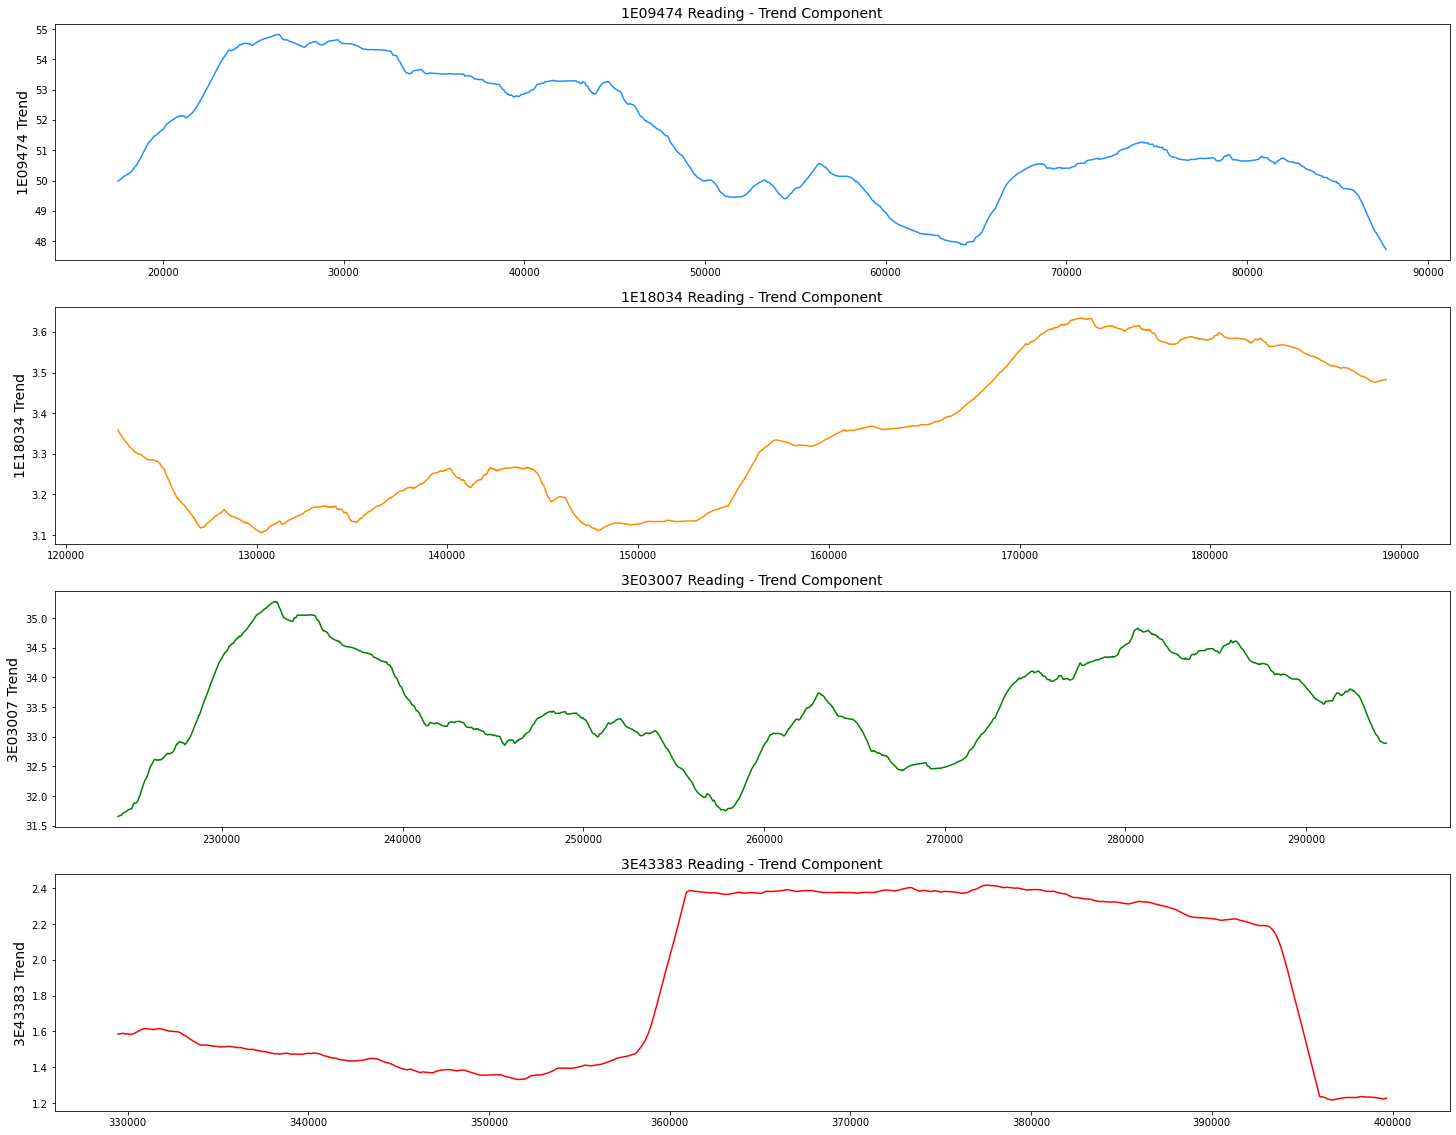

In [15]:
#Trend plot for each asset

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 20))

result_1E09474.trend.plot(ax=ax[0], color='dodgerblue', label = 'trend')
ax[0].set_title(f'1E09474 Reading - Trend Component', fontsize=14)
ax[0].set_ylabel(ylabel='1E09474 Trend', fontsize=14)

result_1E18034.trend.plot(ax=ax[1], color='darkorange', label = 'trend')
ax[1].set_title(f'1E18034 Reading - Trend Component', fontsize=14)
ax[1].set_ylabel(ylabel='1E18034 Trend', fontsize=14)

result_3E03007.trend.plot(ax=ax[2], color='green', label = 'trend')
ax[2].set_title(f'3E03007 Reading - Trend Component', fontsize=14)
ax[2].set_ylabel(ylabel='3E03007 Trend', fontsize=14)

result_3E43383.trend.plot(ax=ax[3], color='red', label = 'trend')
ax[3].set_title(f'3E43383 Reading - Trend Component', fontsize=14)
ax[3].set_ylabel(ylabel='3E43383 Trend', fontsize=14)

Text(0, 0.5, '3E43383 Residual')

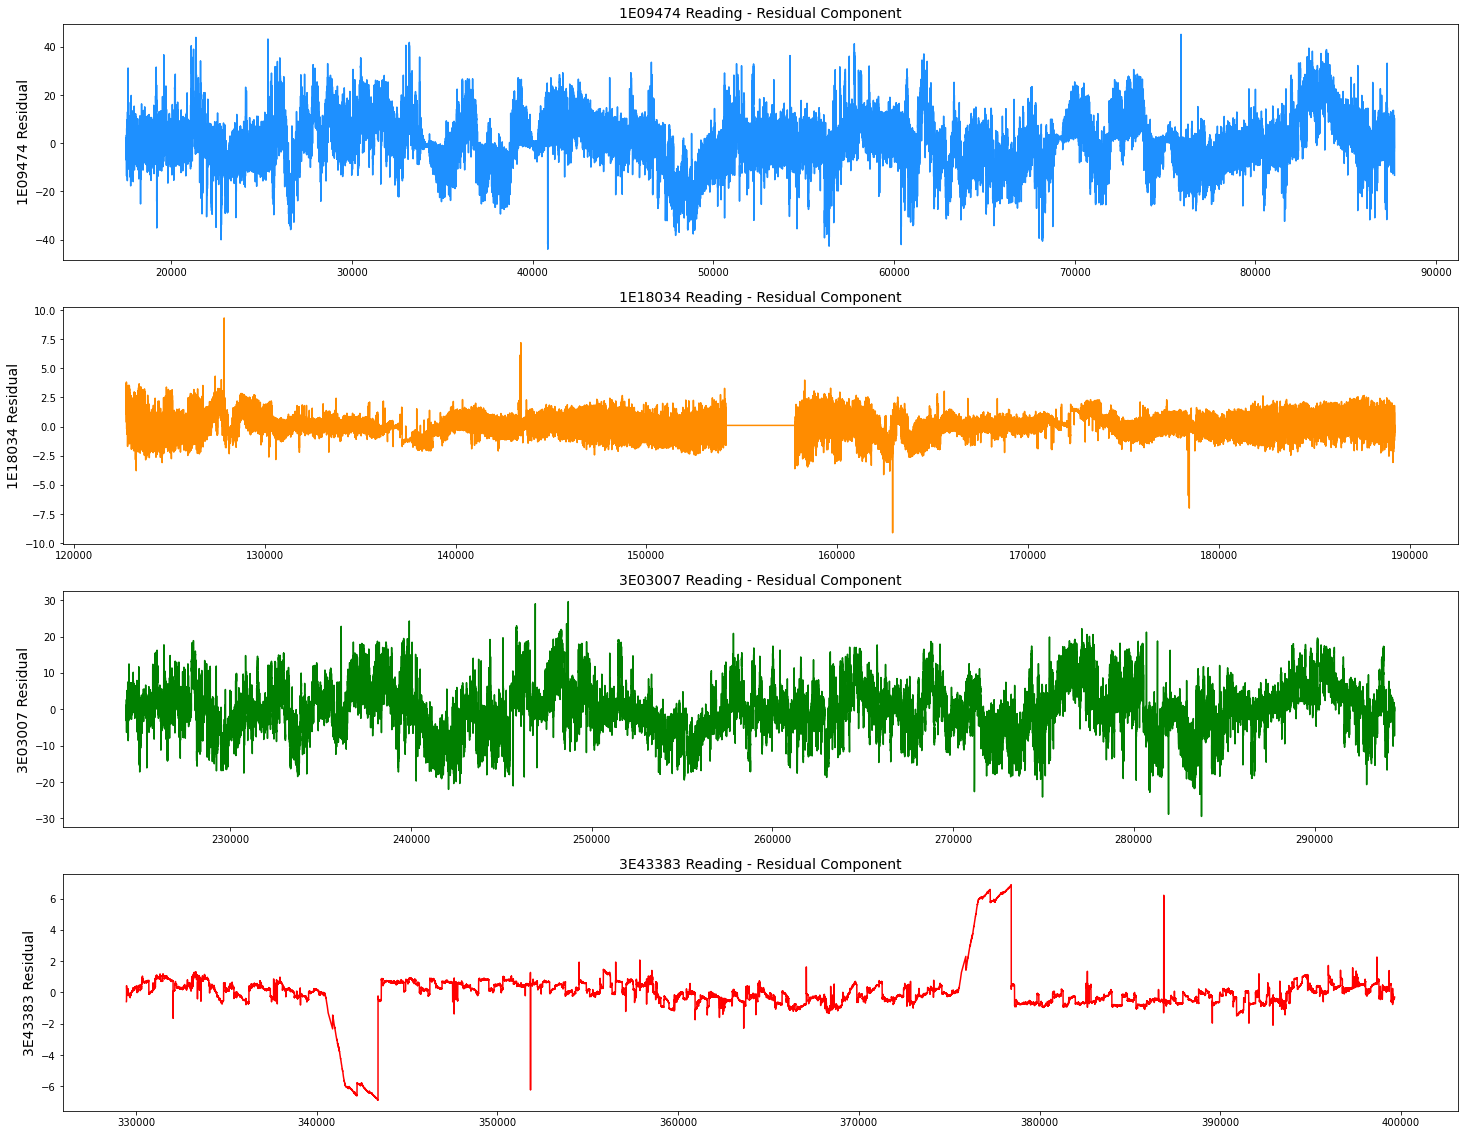

In [16]:
# result.plot()

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 20))

result_1E09474.resid.plot(ax=ax[0], color='dodgerblue', label = 'Residual')
ax[0].set_title(f'1E09474 Reading - Residual Component', fontsize=14)
ax[0].set_ylabel(ylabel='1E09474 Residual', fontsize=14)

result_1E18034.resid.plot(ax=ax[1], color='darkorange', label = 'Residual')
ax[1].set_title(f'1E18034 Reading - Residual Component', fontsize=14)
ax[1].set_ylabel(ylabel='1E18034 Residual', fontsize=14)

result_3E03007.resid.plot(ax=ax[2], color='green', label = 'Residual')
ax[2].set_title(f'3E03007 Reading - Residual Component', fontsize=14)
ax[2].set_ylabel(ylabel='3E03007 Residual', fontsize=14)

result_3E43383.resid.plot(ax=ax[3], color='red', label = 'Residual')
ax[3].set_title(f'3E43383 Reading - Residual Component', fontsize=14)
ax[3].set_ylabel(ylabel='3E43383 Residual', fontsize=14)

In [17]:
# px.scatter(telemetry, x = "FullDate", y = "Reading_Imp", trendline = "ols", color = 'AssetID', trendline_color_override = "yellow")
# # px.scatter(df_1E09474, x = "FullDate", y = "Reading_Imp", trendline = "ols", trendline_color_override = "red")

In [18]:
# plt.figure(figsize=(12, 6))
# heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Correlation Heatmap - Fill null with median', fontdict={'fontsize':12}, pad=10);

In [19]:
# a = train[["store_nbr", "sales"]]
# a["ind"] = 1
# a["ind"] = a.groupby("store_nbr").ind.cumsum().values
# a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
# mask = np.triu(a.corr())
# plt.figure(figsize=(20, 20))
# sns.heatmap(a,
#         annot=True,
#         fmt='.1f',
#         cmap='coolwarm',
#         square=True,
#         mask=mask,
#         linewidths=1,
#         cbar=False)
# plt.title("Correlations among stores",fontsize = 20)
# plt.show()

In [20]:
# df_1E09474
# df_1E18034
# df_3E03007
# df_3E43383

# Asset 1

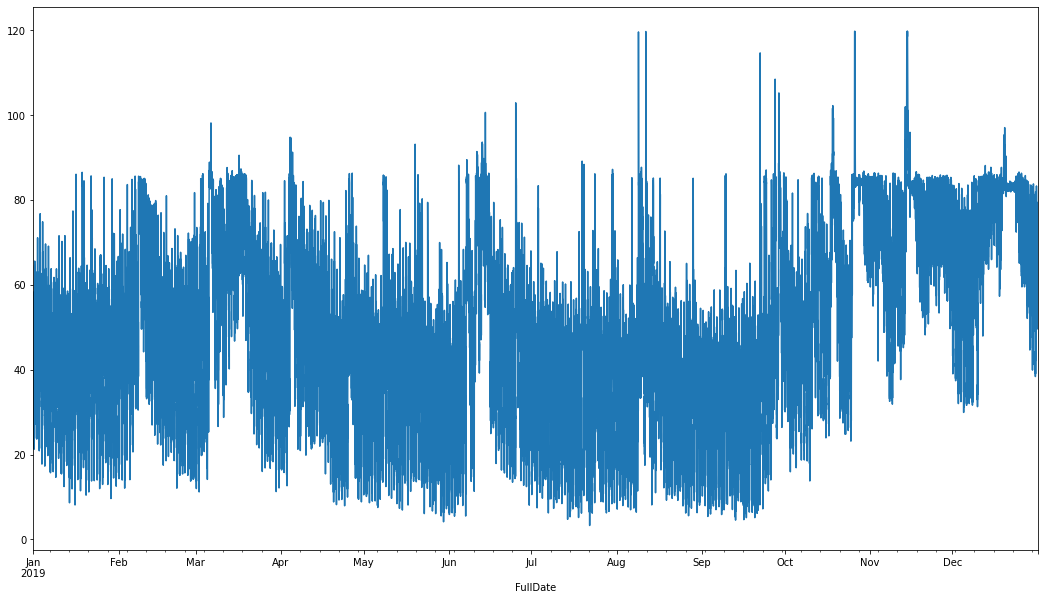

In [21]:
# use specific time frame for simplicity

df_1E09474_section1 = df_1E09474[(df_1E09474['FullDate']<='2019-12-31 23:45:00')]
df_1E09474_section1 = df_1E09474_section1.set_index('FullDate')
df_1E09474_section1.Reading_Imp.plot()
plt.rc("figure", figsize=(18,5))
plt.show()

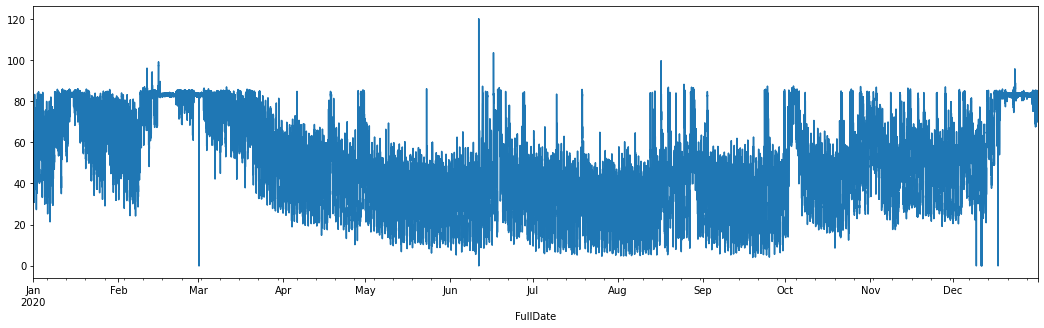

In [22]:
df_1E09474_section2 = df_1E09474[(df_1E09474['FullDate']>='2020-01-01 00:00:00')&(df_1E09474['FullDate']<='2020-12-31 23:45:00')]
df_1E09474_section2 = df_1E09474_section2.set_index('FullDate')
df_1E09474_section2.Reading_Imp.plot()
plt.show()

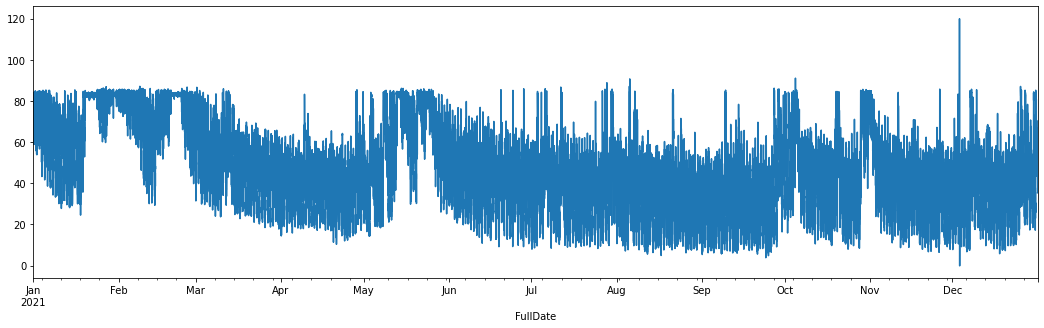

In [23]:
df_1E09474_section3 = df_1E09474[(df_1E09474['FullDate']>='2021-01-01 00:00:00')&(df_1E09474['FullDate']<='2021-12-31 23:45:00')]
df_1E09474_section3 = df_1E09474_section3.set_index('FullDate')
df_1E09474_section3.Reading_Imp.plot()
plt.show()

<AxesSubplot:>

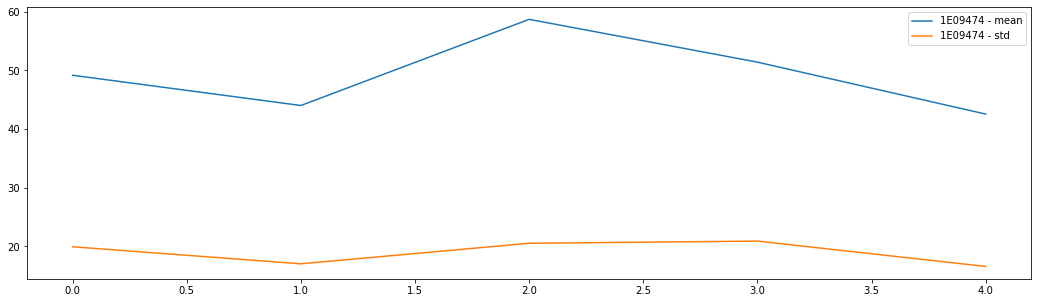

In [24]:

### WHITE NOISE DETECTION

#Split the data set into 4 chunks, create a different data frame with mean and standard deviation of each data frame. Now plot to see if the is difference in mean and std.
df_1E09474_split = np.array_split(df_1E09474, 4)

df_1E09474_stats = pd.DataFrame(np.array([[df_1E09474['Reading_Imp'].mean(), df_1E09474['Reading_Imp'].std()],
                                  [df_1E09474_split[0]['Reading_Imp'].mean(), df_1E09474_split[0]['Reading_Imp'].std()], 
                                  [df_1E09474_split[1]['Reading_Imp'].mean(), df_1E09474_split[1]['Reading_Imp'].std()],
                                  [df_1E09474_split[2]['Reading_Imp'].mean(), df_1E09474_split[2]['Reading_Imp'].std()],
                                  [df_1E09474_split[3]['Reading_Imp'].mean(), df_1E09474_split[3]['Reading_Imp'].std()]]),
                    columns=['1E09474 - mean', '1E09474 - std'])
df_1E09474_stats.plot()

We can see that the mean of asset 1 is not constant and its fluctuating

<AxesSubplot:>

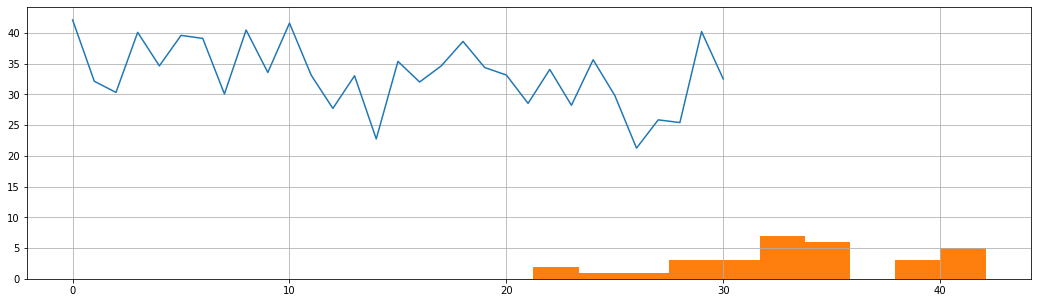

In [25]:
# Plotting it just for 1st month as I see similar pattern across. Avoids clutter
df_1E09474['Reading_Imp'][:31].plot()
df_1E09474['Reading_Imp'][:31].hist()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

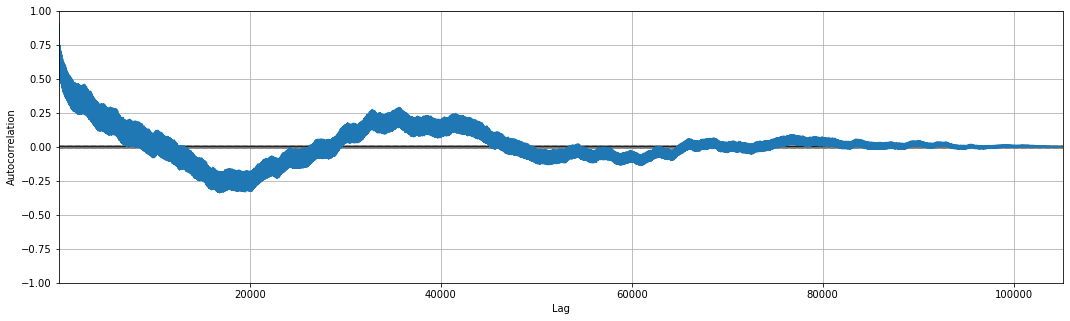

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_1E09474['Reading_Imp'])

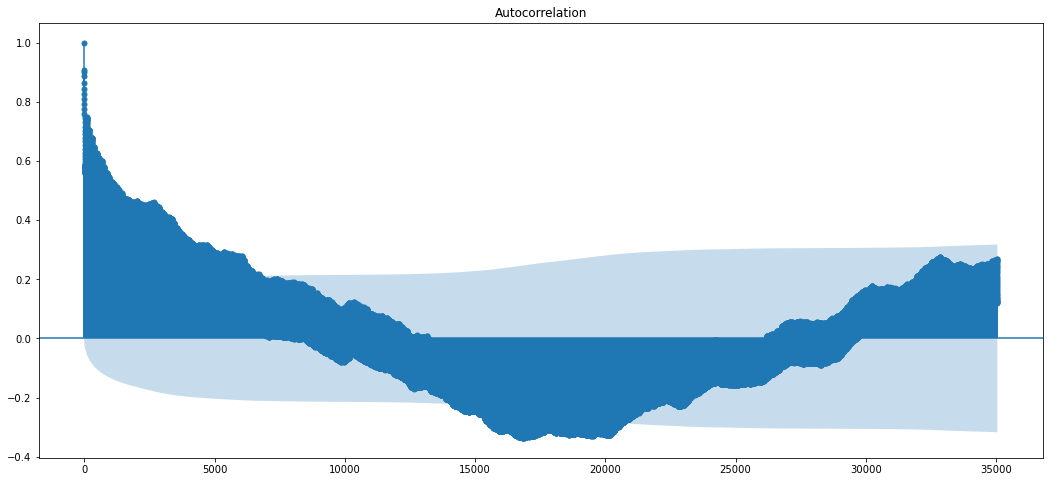

In [65]:
# from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(20,10))
# plt.rc("figure", figsize=(18,8))
plot_acf(df_1E09474['Reading_Imp'], lags=35040)
plt.show()

In [28]:
df_1E09474

,AssetID,FullDate,Date,Time,snoIdentifier,tidIdentifier,Reading,YM,Year,Month,delta_premerge,delta_pm_mins,BST_Y,Invalid_Y,OriginalRecord_Y,Reading_Imp
0,1E09474,2019-01-01 00:00:00,2019-01-01,00:00:00,1.0,E09474,42.10,2019-01,2019.0,1.0,NaN,NaN,0,0,1,42.10
1,1E09474,2019-01-01 00:15:00,2019-01-01,00:15:00,1.0,E09474,32.13,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,32.13
2,1E09474,2019-01-01 00:30:00,2019-01-01,00:30:00,1.0,E09474,30.31,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,30.31
3,1E09474,2019-01-01 00:45:00,2019-01-01,00:45:00,1.0,E09474,40.08,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,40.08
4,1E09474,2019-01-01 01:00:00,2019-01-01,01:00:00,1.0,E09474,34.63,2019-01,2019.0,1.0,0 days 00:15:00,15.0,0,0,1,34.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105211,1E09474,2021-12-31 22:45:00,2021-12-31,22:45:00,1.0,E09474,41.07,2021-12,2021.0,12.0,0 days 00:15:00,15.0,0,0,1,41.07
105212,1E09474,2021-12-31 23:00:00,2021-12-31,23:00:00,1.0,E09474,39.39,2021-12,2021.0,12.0,0 days 00:15:00,15.0,0,0,1,39.39
105213,1E09474,2021-12-31 23:15:00,2021-12-31,23:15:00,1.0,E09474,46.37,2021-12,2021.0,12.0,0 days 00:15:00,15.0,0,0,1,46.37
105214,1E09474,2021-12-31 23:30:00,2021-12-31,23:30:00,1.0,E09474,42.40,2021-12,2021.0,12.0,0 days 00:15:00,15.0,0,0,1,42.40


# Asset 2

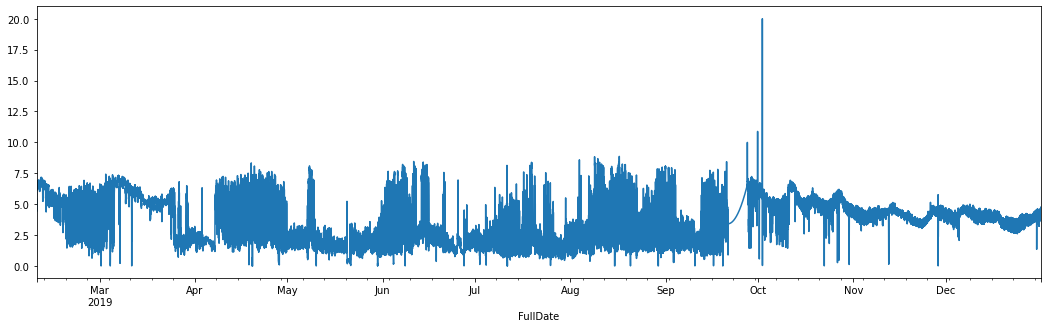

In [29]:
df_1E18034_section1 = df_1E18034[(df_1E18034['FullDate']<='2019-12-31 23:45:00')]
df_1E18034_section1 = df_1E18034_section1.set_index('FullDate')
df_1E18034_section1.Reading_Imp.plot()
plt.show()

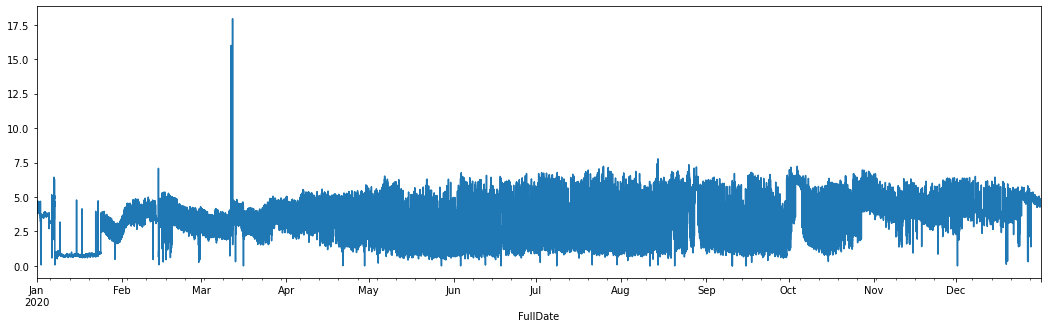

In [30]:
df_1E18034_section2 = df_1E18034[(df_1E18034['FullDate']>='2020-01-01 00:00:00')&(df_1E18034['FullDate']<='2020-12-31 23:45:00')]
df_1E18034_section2 = df_1E18034_section2.set_index('FullDate')
df_1E18034_section2.Reading_Imp.plot()
plt.show()

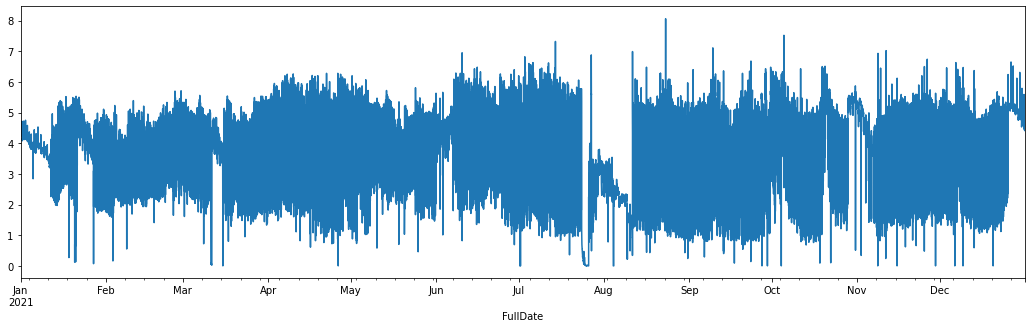

In [31]:
df_1E18034_section3 = df_1E18034[(df_1E18034['FullDate']>='2021-01-01 00:00:00')&(df_1E18034['FullDate']<='2021-12-31 23:45:00')]
df_1E18034_section3 = df_1E18034_section3.set_index('FullDate')
df_1E18034_section3.Reading_Imp.plot()
plt.show()

<AxesSubplot:>

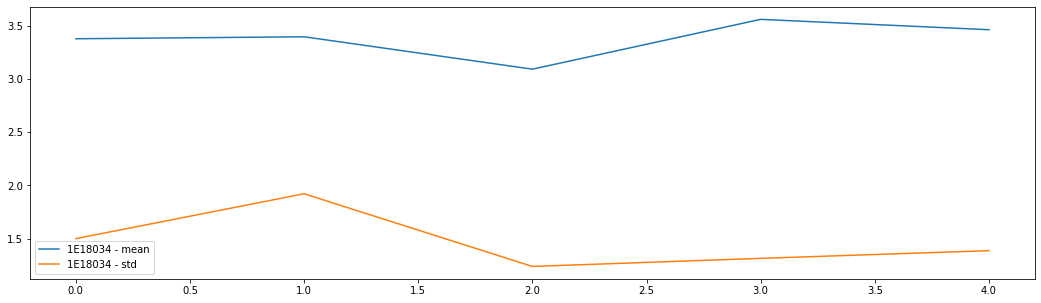

In [32]:
### WHITE NOISE DETECTION

#Split the data set into 4 chunks, create a different data frame with mean and standard deviation of each data frame. Now plot to see if the is difference in mean and std.
df_1E18034_split = np.array_split(df_1E18034, 4)

df_1E18034_stats = pd.DataFrame(np.array([[df_1E18034['Reading_Imp'].mean(), df_1E18034['Reading_Imp'].std()],
                                  [df_1E18034_split[0]['Reading_Imp'].mean(), df_1E18034_split[0]['Reading_Imp'].std()], 
                                  [df_1E18034_split[1]['Reading_Imp'].mean(), df_1E18034_split[1]['Reading_Imp'].std()],
                                  [df_1E18034_split[2]['Reading_Imp'].mean(), df_1E18034_split[2]['Reading_Imp'].std()],
                                  [df_1E18034_split[3]['Reading_Imp'].mean(), df_1E18034_split[3]['Reading_Imp'].std()]]),
                    columns=['1E18034 - mean', '1E18034 - std'])
df_1E18034_stats.plot()

<AxesSubplot:>

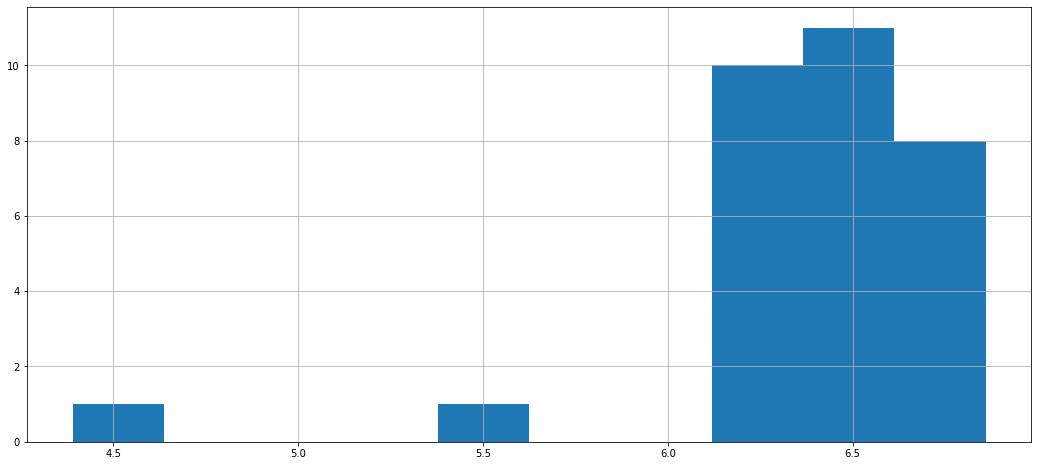

In [63]:
# Plotting it just for 1st month as I see similar pattern across. Avoids clutter
# df_1E18034['Reading_Imp'][:31].plot()
df_1E18034['Reading_Imp'][:31].hist()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

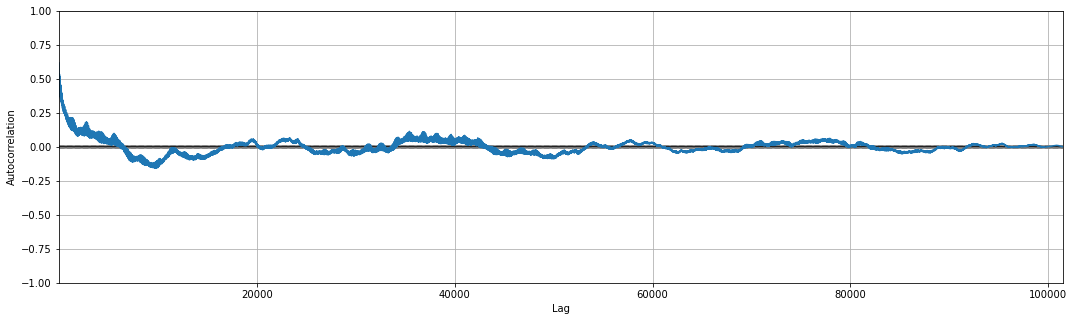

In [34]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_1E18034['Reading_Imp'])

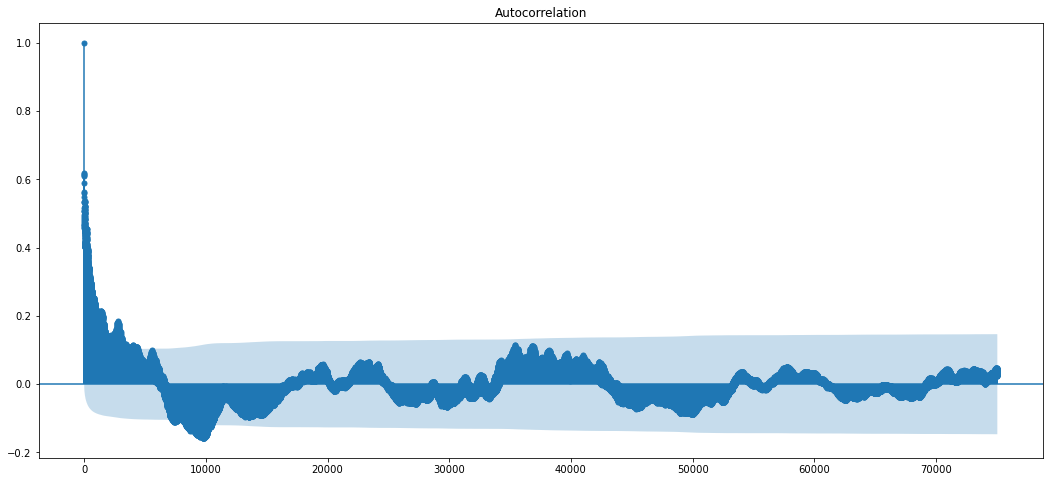

In [66]:
# from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(20,10))
# plt.rc("figure", figsize=(18,8))
plot_acf(df_1E18034['Reading_Imp'], lags=75040)
plt.show()

# Asset 3

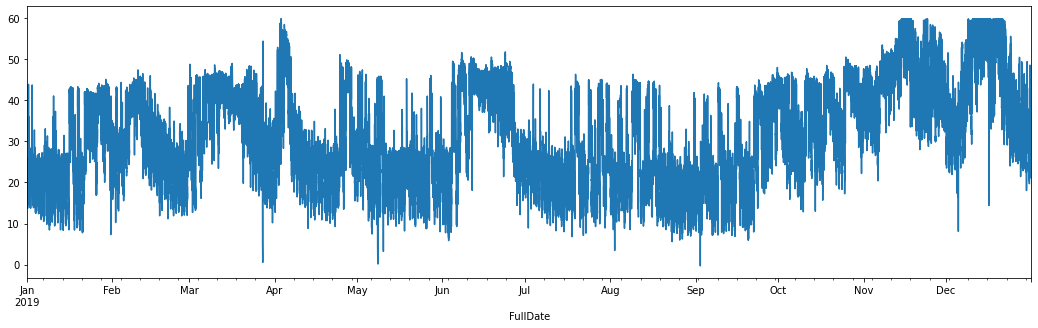

In [36]:
df_3E03007_section1 = df_3E03007[(df_3E03007['FullDate']<='2019-12-31 23:45:00')]
df_3E03007_section1 = df_3E03007_section1.set_index('FullDate')
df_3E03007_section1.Reading_Imp.plot()
plt.show()

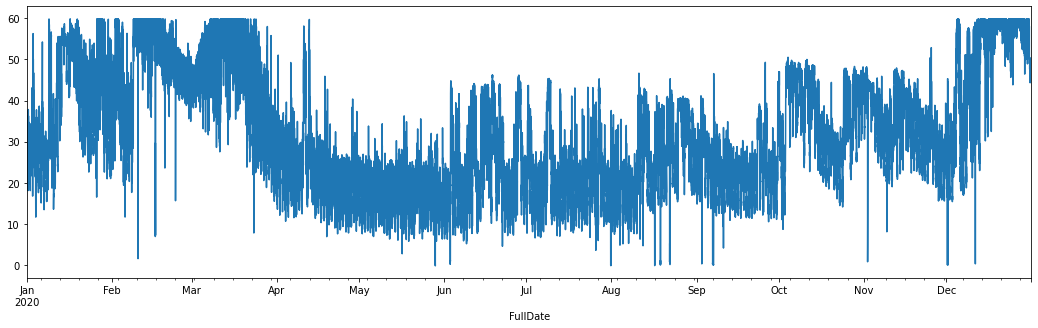

In [37]:
df_3E03007_section2 = df_3E03007[(df_3E03007['FullDate']>='2020-01-01 00:00:00')&(df_3E03007['FullDate']<='2020-12-31 23:45:00')]
df_3E03007_section2 = df_3E03007_section2.set_index('FullDate')
df_3E03007_section2.Reading_Imp.plot()
plt.show()

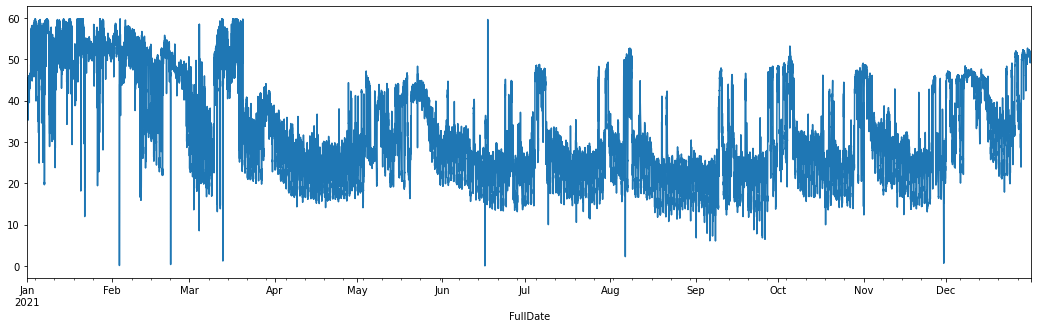

In [38]:
df_3E03007_section3 = df_3E03007[(df_3E03007['FullDate']>='2021-01-01 00:00:00')&(df_3E03007['FullDate']<='2021-12-31 23:45:00')]
df_3E03007_section3 = df_3E03007_section3.set_index('FullDate')
df_3E03007_section3.Reading_Imp.plot()
plt.show()

<AxesSubplot:>

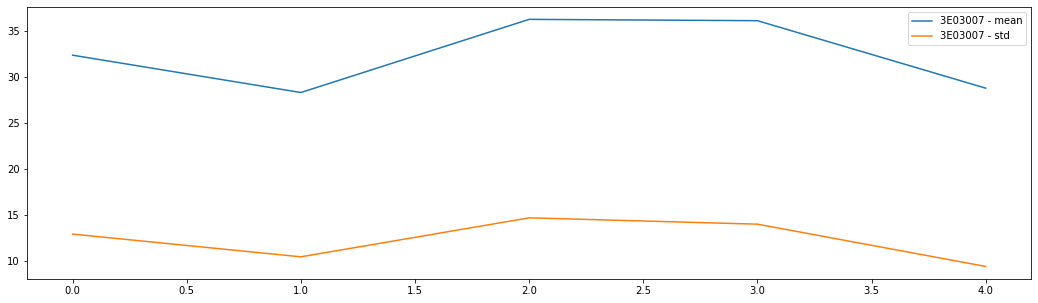

In [39]:
### WHITE NOISE DETECTION

#Split the data set into 4 chunks, create a different data frame with mean and standard deviation of each data frame. Now plot to see if the is difference in mean and std.
df_3E03007_split = np.array_split(df_3E03007, 4)

df_3E03007_stats = pd.DataFrame(np.array([[df_3E03007['Reading_Imp'].mean(), df_3E03007['Reading_Imp'].std()],
                                  [df_3E03007_split[0]['Reading_Imp'].mean(), df_3E03007_split[0]['Reading_Imp'].std()], 
                                  [df_3E03007_split[1]['Reading_Imp'].mean(), df_3E03007_split[1]['Reading_Imp'].std()],
                                  [df_3E03007_split[2]['Reading_Imp'].mean(), df_3E03007_split[2]['Reading_Imp'].std()],
                                  [df_3E03007_split[3]['Reading_Imp'].mean(), df_3E03007_split[3]['Reading_Imp'].std()]]),
                    columns=['3E03007 - mean', '3E03007 - std'])
df_3E03007_stats.plot()

<AxesSubplot:>

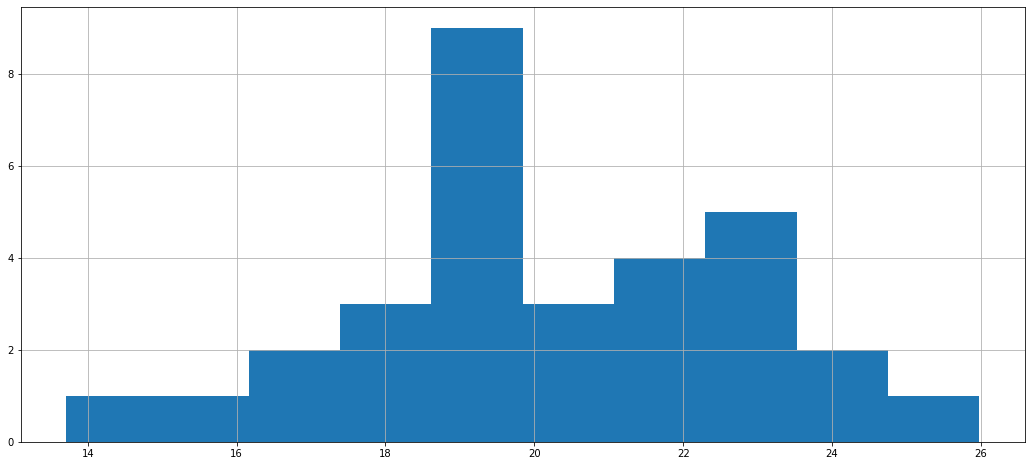

In [62]:
# Plotting it just for 1st month as I see similar pattern across. Avoids clutter
# df_3E03007['Reading_Imp'][90:120].plot()
df_3E03007['Reading_Imp'][:31].hist()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

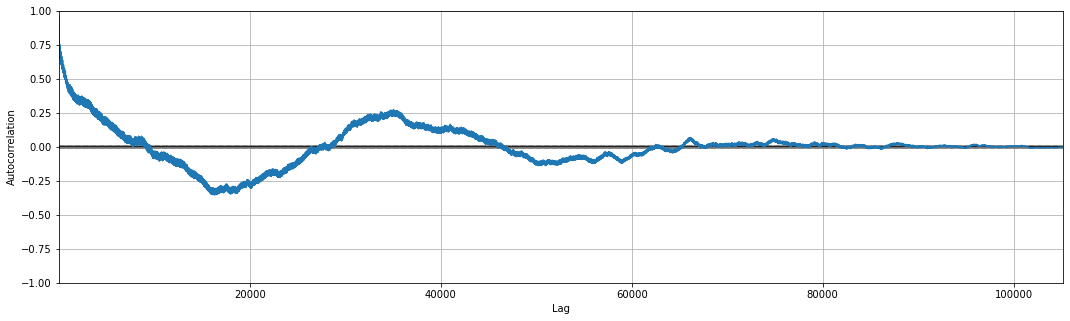

In [41]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_3E03007['Reading_Imp'])

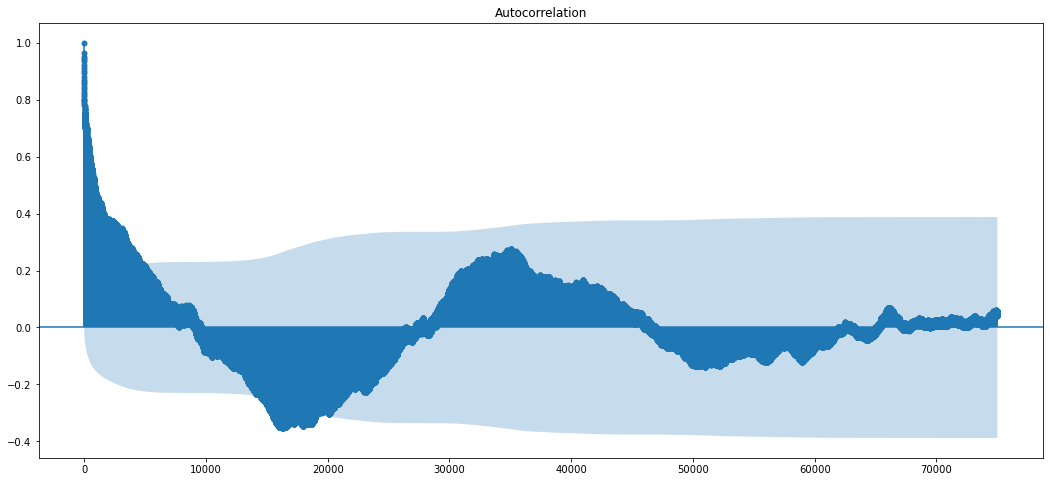

In [67]:
# from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(20,10))
plt.rc("figure", figsize=(18,8))
plot_acf(df_3E03007['Reading_Imp'], lags =75000)
plt.show()

# Asset 4

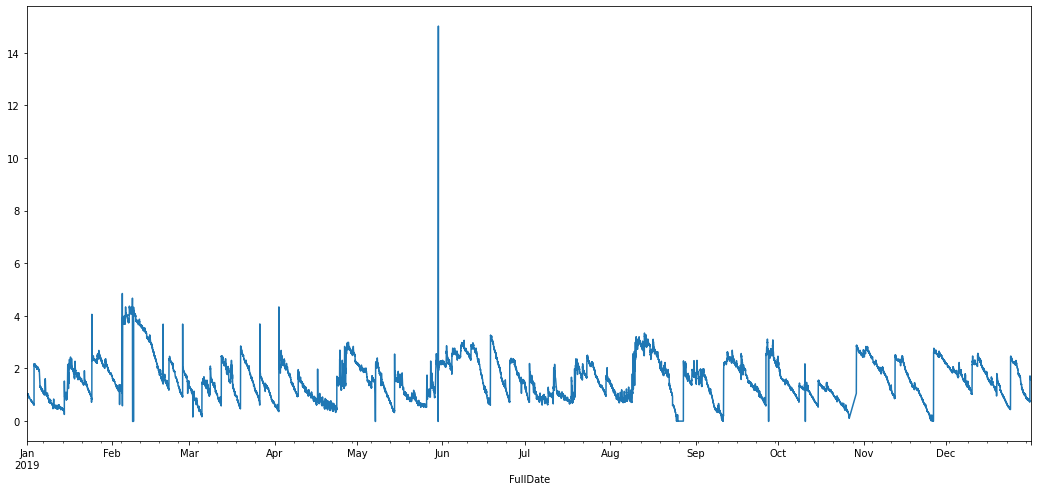

In [43]:
df_3E43383_section1 = df_3E43383[(df_3E43383['FullDate']<='2019-12-31 23:45:00')]
df_3E43383_section1 = df_3E43383_section1.set_index('FullDate')
df_3E43383_section1.Reading_Imp.plot()
plt.show()



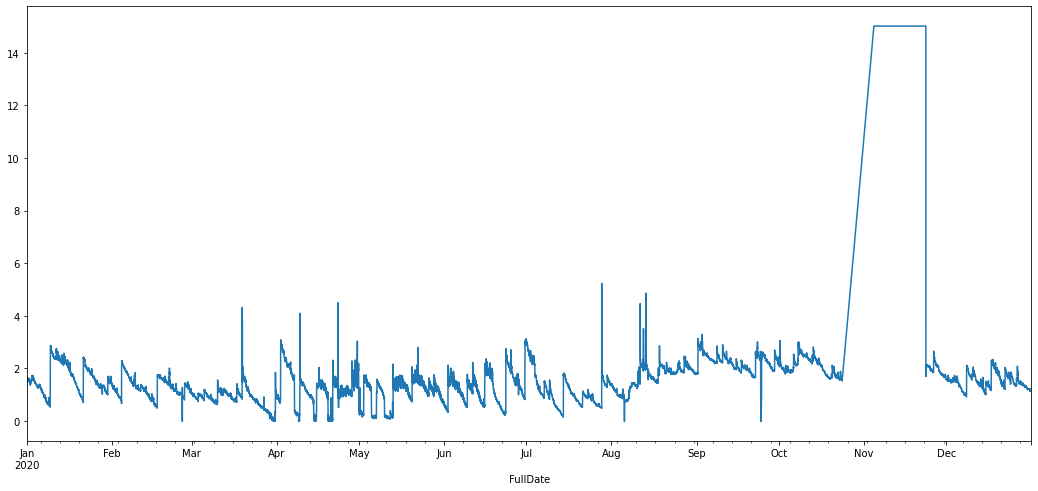

In [44]:
df_3E43383_section2 = df_3E43383[(df_3E43383['FullDate']>='2020-01-01 00:00:00')&(df_3E43383['FullDate']<='2020-12-31 23:45:00')]
df_3E43383_section2 = df_3E43383_section2.set_index('FullDate')
df_3E43383_section2.Reading_Imp.plot()
plt.show()

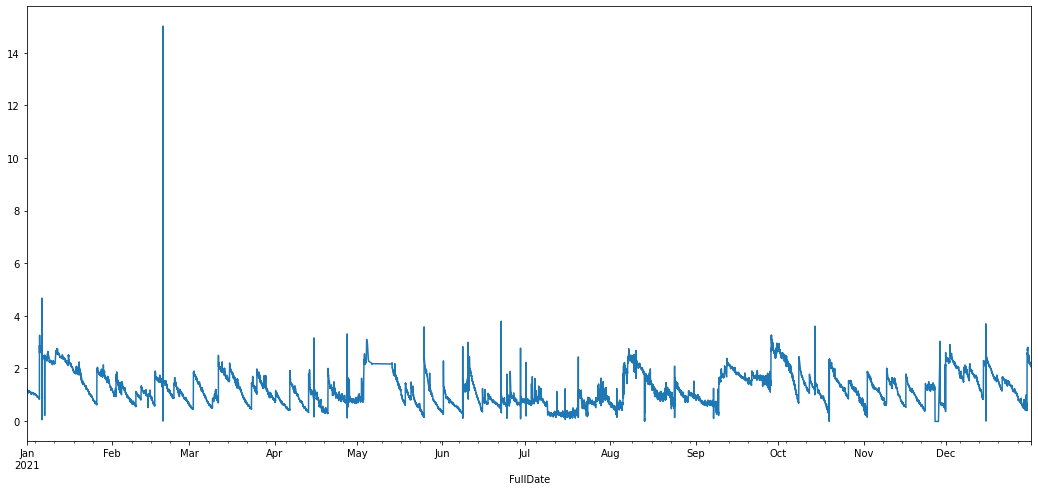

In [45]:
df_3E43383_section3 = df_3E43383[(df_3E43383['FullDate']>='2021-01-01 00:00:00')&(df_3E43383['FullDate']<='2021-12-31 23:45:00')]
df_3E43383_section3 = df_3E43383_section3.set_index('FullDate')
df_3E43383_section3.Reading_Imp.plot()
plt.show()

<AxesSubplot:>

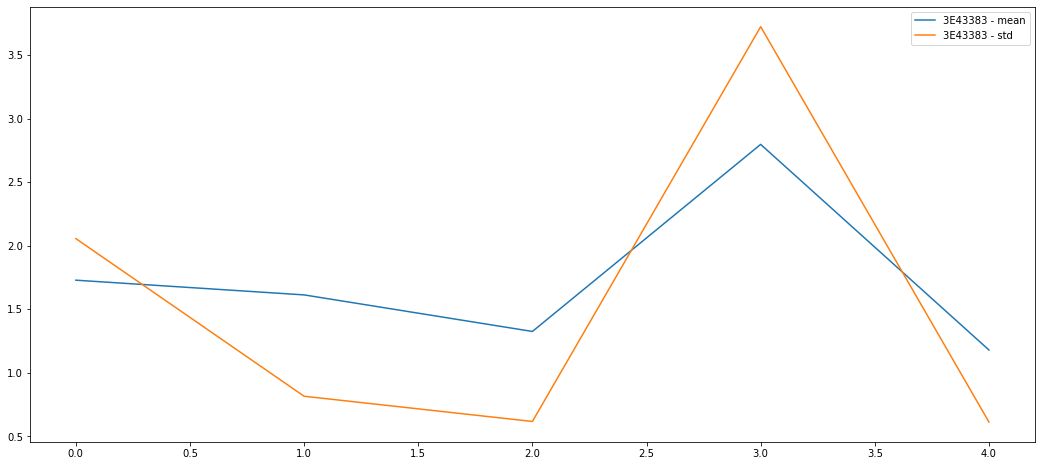

In [46]:
### WHITE NOISE DETECTION

#Split the data set into 4 chunks, create a different data frame with mean and standard deviation of each data frame. Now plot to see if the is difference in mean and std.
df_3E43383_split = np.array_split(df_3E43383, 4)

df_3E43383_stats = pd.DataFrame(np.array([[df_3E43383['Reading_Imp'].mean(), df_3E43383['Reading_Imp'].std()],
                                  [df_3E43383_split[0]['Reading_Imp'].mean(), df_3E43383_split[0]['Reading_Imp'].std()], 
                                  [df_3E43383_split[1]['Reading_Imp'].mean(), df_3E43383_split[1]['Reading_Imp'].std()],
                                  [df_3E43383_split[2]['Reading_Imp'].mean(), df_3E43383_split[2]['Reading_Imp'].std()],
                                  [df_3E43383_split[3]['Reading_Imp'].mean(), df_3E43383_split[3]['Reading_Imp'].std()]]),
                    columns=['3E43383 - mean', '3E43383 - std'])
df_3E43383_stats.plot()

<AxesSubplot:>

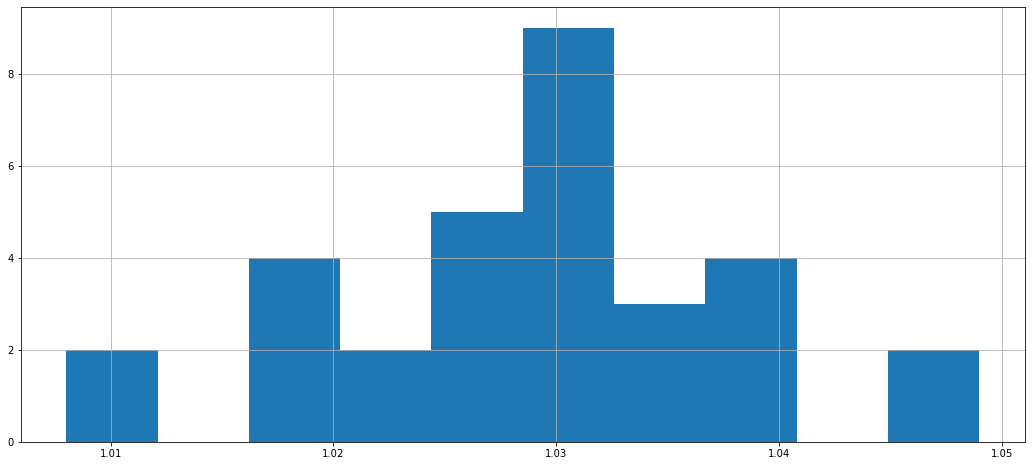

In [61]:
# Plotting it just for 1st month as I see similar pattern across. Avoids clutter
# df_3E43383['Reading_Imp'].plot()
df_3E43383['Reading_Imp'][:31].hist()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

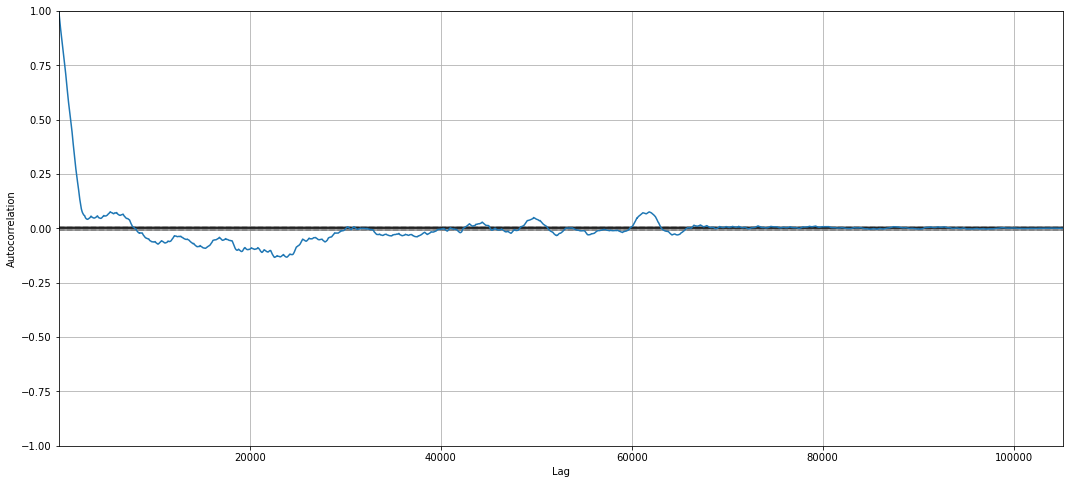

In [48]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_3E43383['Reading_Imp'])

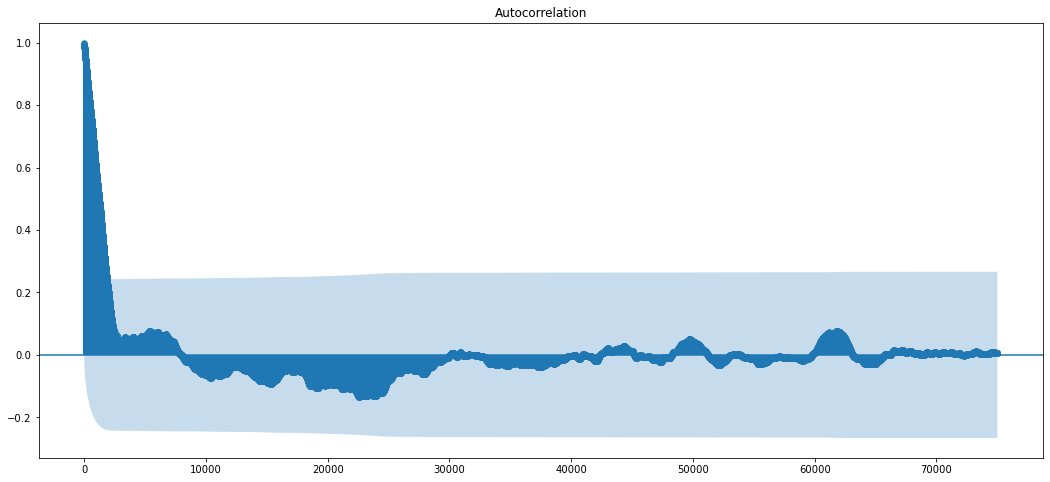

In [68]:
# from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(20,10))
# plt.rc("figure", figsize=(18,8))
plot_acf(df_3E43383['Reading_Imp'],lags=75000)
plt.show()